# Project 242

## Import

In [31]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [33]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


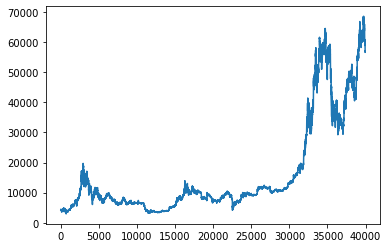

In [34]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [35]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})
data.columns

Index(['open', 'high', 'low', 'close', 'Volume'], dtype='object')

Here, we can decide to add features ...

In [36]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [37]:
data.loc[data['VWAP'].isna(), 'VWAP'] = 0

In [38]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 13) | X_test: (9978, 13)


In [40]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [41]:
# Add Signal
#q_90 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.9)

train_data = add_signal(train_data, 0.001)
test_data = add_signal(test_data, 0.001)
#train_data['Signal'] = (train_data['Return'] >0).apply(int)
#test_data['Signal'] = (test_data['Return'] >0).apply(int)

In [42]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (38.0%) | 0 (26.0%) | -1 (36.0%)
Test set: 1 (42.0%) | 0 (19.0%) | -1 (39.0%)


In [43]:
#display(train_data.head(2))
test_data['Signal'].describe()

count    9978.000000
mean        0.028763
std         0.899854
min        -1.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Signal, dtype: float64

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [44]:
train = prepare_data_2D_format(train_data)
test = prepare_data_2D_format(test_data, undersample = False)
test = test[:-10]

X_train = train
X_train = X_train.drop(['Signal'], axis = 1)
y_train = train['Signal']

X_test = test
X_test = X_test.drop(['Signal'], axis = 1)
y_test = test['Signal']

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# ccp_alpha values
grid_values = {'ccp_alpha': np.linspace(0, 0.003, 20),
              'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]}

# Regression Tree
dtc = DecisionTreeClassifier()

# Regression Tree for all ccp_alpha
dtc_cv = GridSearchCV(dtc, param_grid=grid_values, scoring='accuracy', cv=5, verbose=1)
dtc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.00015789, 0.00031579, 0.00047368, 0.00063158,
       0.00078947, 0.00094737, 0.00110526, 0.00126316, 0.00142105,
       0.00157895, 0.00173684, 0.00189474, 0.00205263, 0.00221053,
       0.00236842, 0.00252632, 0.00268421, 0.00284211, 0.003     ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='accuracy', verbose=1)

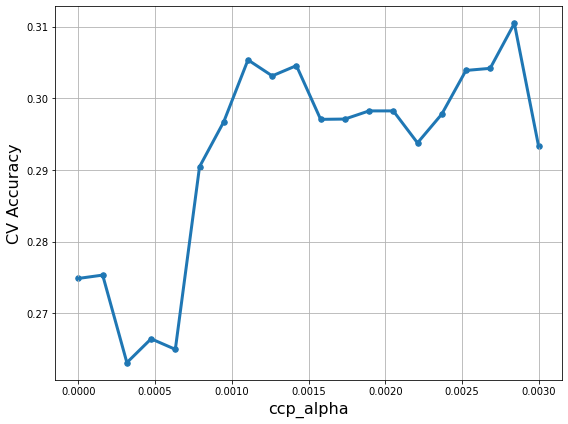

In [46]:
## The goal here is to plot accuracy scores with respect to ccp_alpha, to justify my choice
import matplotlib.pyplot as plt

acc_scores = dtc_cv.cv_results_['mean_test_score']
ccp_alpha = dtc_cv.cv_results_['param_ccp_alpha'].data

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.scatter(ccp_alpha,acc_scores, s=30)
plt.plot(ccp_alpha, acc_scores, linewidth=3)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

In [47]:
print('Best ccp_alpha: ', dtc_cv.best_params_['ccp_alpha'])
print('Best Accuracy: ', dtc_cv.best_score_)

Best ccp_alpha:  0.002842105263157895
Best Accuracy:  0.3104589534577685


Node count: 5


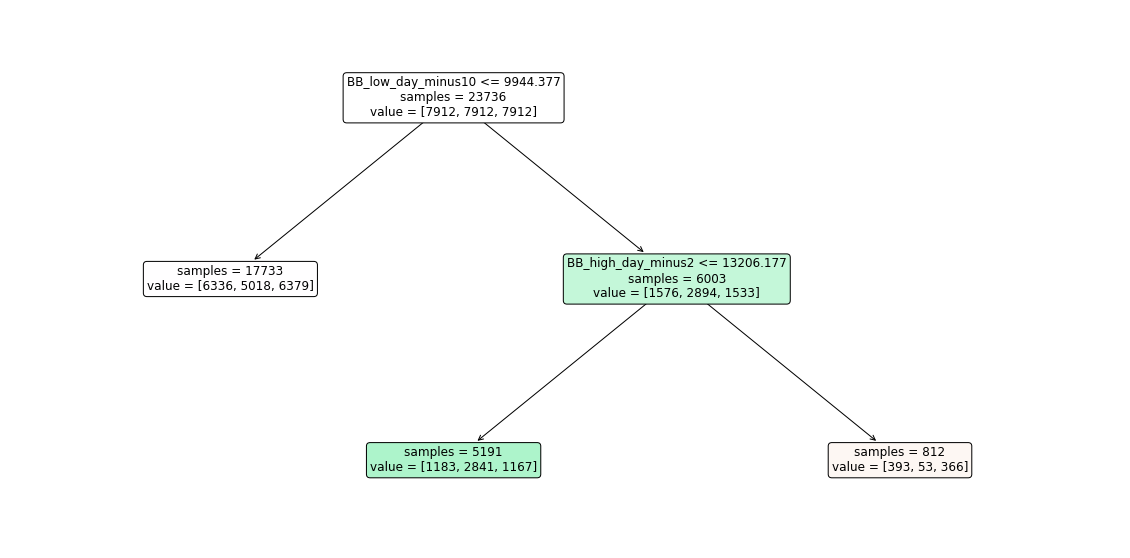

In [48]:
from sklearn.tree import plot_tree
print('Node count:', dtc_cv.best_estimator_.tree_.node_count)
plt.figure(figsize=(20,10))
plot_tree(dtc_cv.best_estimator_, feature_names=X_train.columns, filled=True,impurity=False, rounded=True,
        fontsize=12, max_depth=3)
plt.show()

In [49]:
y_pred = dtc_cv.best_estimator_.predict(X_test)

### 3. Test prediction model

In [50]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [51]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Baseline,0,0,0.394155,0,0


### III. Strategy

### 1. Get data ready for backtesting

In [53]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

count    9958.000000
mean       -0.994376
std         0.074783
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max         0.000000
dtype: float64

In [54]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [55]:
strat = Strategy(cash=500, fees=0.001)

In [56]:
strat.run(signal_crop, close_crop, verbose=False)

In [57]:
wallet = np.array(strat.wallet)
profit_list = [0]
for i in range(1, len(wallet)):
    profit_list.append(wallet[i]-wallet[i-1])
    
profit = np.array(profit_list)

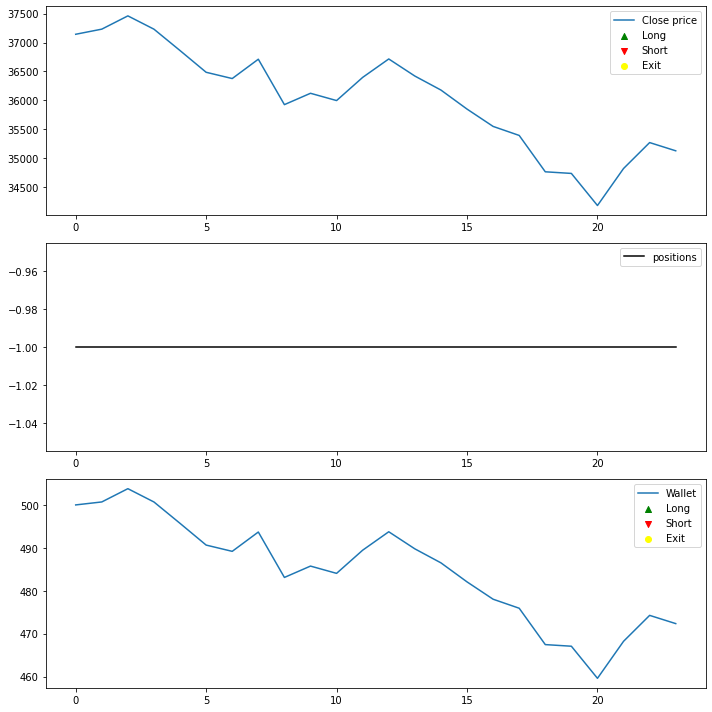

In [58]:
strat.visualize()

### 3. Test performance startegy

In [59]:
c_SharpeRatio = SharpeRatio(profit)
c_MaxDrawback = MaxDrawback(profit)
c_WinLossRatio = WinLossRatio(profit)
c_CumulativeProfit = CumulativeProfit(profit)
c_MeanProfit = MeanProfit(profit)

In [60]:
models = ['CART']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[c_SharpeRatio, c_MaxDrawback, c_WinLossRatio, c_CumulativeProfit, c_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
CART,-0.237871,-10.579685,0.533333,-27.648769,-1.105951
